<a href="https://colab.research.google.com/github/sarmi2325/Machine-Learning/blob/main/Pneumonia_prediction_using_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [4]:
from tensorflow.keras import layers

#Implementing Data Augmentation for better generalization and to avoid overfitting
#Since it is a medical dataset, heavy data augumentation will mislead the data. Hence brightness and contrast is implemented
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2),  # Brightness adjustment ±20%
    layers.RandomContrast(factor=0.2)     # Contrast adjustment ±20%
])

In [5]:
#import libraries for training the model
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetB0 #chossing EfficientNetB0 as it is a light weight model and give better accuracy for binary image classification
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np

In [7]:
# Base model with pretrained ImageNet weights
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze all layers initially
# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train (initial training, frozen base)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,

)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 1735s 8s/step - accuracy: 0.5538 - loss: 0.6895 - val_accuracy: 0.8788 - val_loss: 0.4871
Epoch 2/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 129s 425ms/step - accuracy: 0.8167 - loss: 0.4936 - val_accuracy: 0.8891 - val_loss: 0.3804
Epoch 3/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 129s 364ms/step - accuracy: 0.8689 - loss: 0.3979 - val_accuracy: 0.8933 - val_loss: 0.3267
Epoch 4/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 91s 406ms/step - accuracy: 0.8742 - loss: 0.3560 - val_accuracy: 0.8976 - val_loss: 0.2940
Epoch 5/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 142s 408ms/step - accuracy: 0.8843 - loss: 0.3237 - val_accuracy: 0.9027 - val_loss: 0.2724
Epoch 6/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 87s 409ms/step - accuracy: 0.8882 - loss: 0.3036 - val_accuracy: 0.9036 - val_loss: 0.2570


In [8]:
# Unfreeze top 5 layers
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 123s 458ms/step - accuracy: 0.8904 - loss: 0.2998 - val_accuracy: 0.9104 - val_loss: 0.2279
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - accuracy: 0.9039 - loss: 0.2569 - val_accuracy: 0.9206 - val_loss: 0.1997
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.9106 - loss: 0.2373 - val_accuracy: 0.9266 - val_loss: 0.1821
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 152s 461ms/step - accuracy: 0.9202 - loss: 0.2104 - val_accuracy: 0.9317 - val_loss: 0.1691
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 131s 408ms/step - accuracy: 0.9174 - loss: 0.2134 - val_accuracy: 0.9326 - val_loss: 0.1601


In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.9427 - loss: 0.1687

Test Accuracy: 0.9317


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[278  15]
 [ 25 268]]


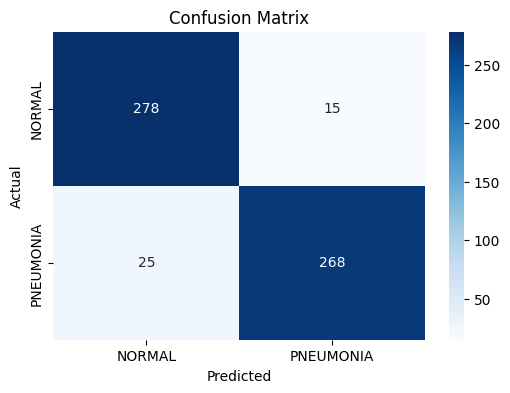


 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.93       293
   PNEUMONIA       0.95      0.91      0.93       293

    accuracy                           0.93       586
   macro avg       0.93      0.93      0.93       586
weighted avg       0.93      0.93      0.93       586



In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [12]:
model.save("pneumonia_model.keras")
from google.colab import files
files.download("pneumonia_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>